In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

import pymc3 as pm
import arviz as az

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

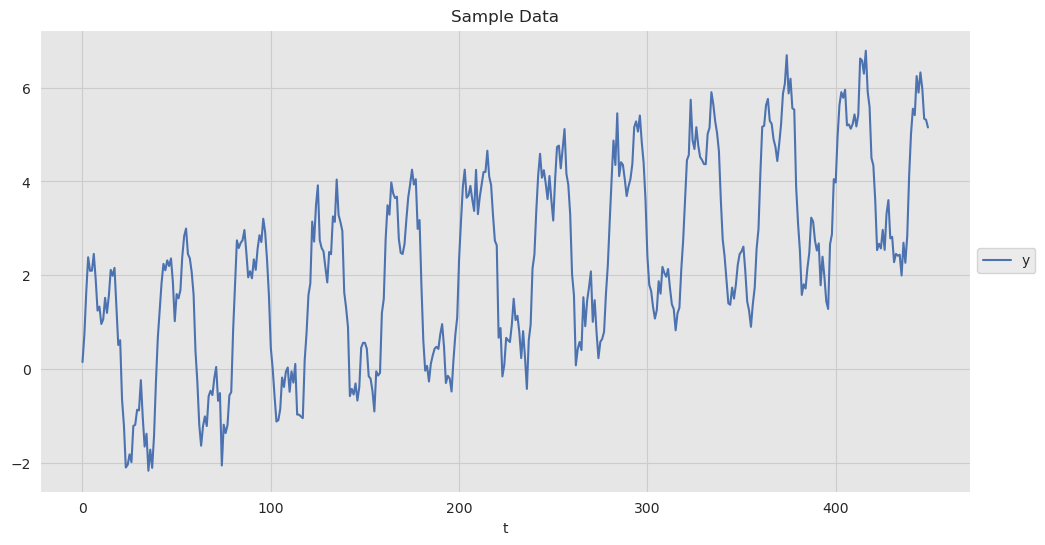

In [3]:
np.random.seed(42)

# Generate seasonal variables. 
def seasonal(t, amplitude, period):
    """Generate a sinusoidal curve."""
    return amplitude * np.sin((2*np.pi*t)/period) 

def generate_data(n, sigma_n = 0.3):
    """Generate sample data. 
    Two seasonal components, one linear trend and gaussian noise.
    """
    # Define "time" variable.
    t = np.arange(n)
    data_df = pd.DataFrame({'t' : t})
    # Add components:
    data_df['epsilon'] = np.random.normal(loc=0, scale=sigma_n, size=n)
    data_df['s1'] = data_df['t'].apply(lambda t: seasonal(t, amplitude=2, period=40)) 
    data_df['s2'] = data_df['t'].apply(lambda t: seasonal(t, amplitude=1, period=13.3)) 
    data_df['tr1'] = 0.01 * data_df['t']
    return data_df.eval('y = s1 + s2 + tr1 + epsilon')


# Number of samples.
n = 450
# Generate data.
data_df = generate_data(n=n)
# Plot. 
fig, ax = plt.subplots()
sns.lineplot(x='t', y='y', data=data_df, color=sns_c[0], label='y', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Sample Data', xlabel='t', ylabel='');

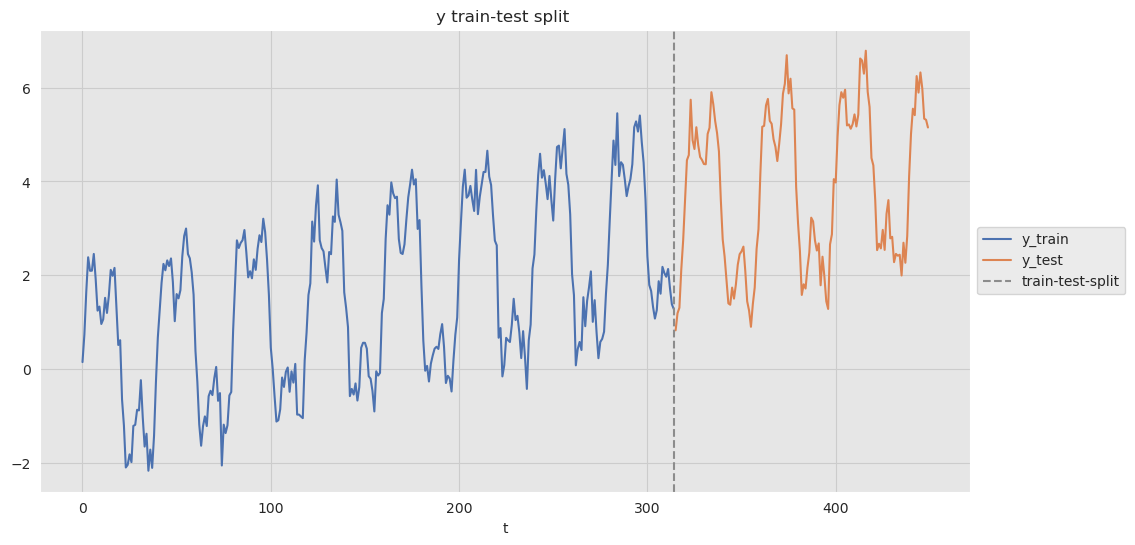

In [4]:
x = data_df['t'].values.reshape(n, 1)
y = data_df['y'].values.reshape(n, 1)

prop_train = 0.7
n_train = round(prop_train * n)

x_train = x[:n_train]
y_train = y[:n_train]

x_test = x[n_train:]
y_test = y[n_train:]

# Plot.
fig, ax = plt.subplots()
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color=sns_c[1], label='y_test', ax=ax)
ax.axvline(x=x_train.flatten()[-1], color=sns_c[7], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='y train-test split ', xlabel='t', ylabel='');

In [5]:
with pm.Model() as model:

    # First seasonal component.
    ls_1 = pm.Gamma(name='ls_1', alpha=2.0, beta=1.0)
    period_1 = pm.Gamma(name='period_1', alpha=80, beta=2)
    gp_1 = pm.gp.Marginal(cov_func=pm.gp.cov.Periodic(input_dim=1, period=period_1, ls=ls_1))
    # Second seasonal component.
    ls_2 = pm.Gamma(name='ls_2', alpha=2.0, beta=1.0)
    period_2 = pm.Gamma(name='period_2', alpha=30, beta=2)
    gp_2 = pm.gp.Marginal(cov_func=pm.gp.cov.Periodic(input_dim=1, period=period_2, ls=ls_2))
    # Linear trend.
    c_3 = pm.Normal(name='c_3', mu=1, sigma=2)
    gp_3 = pm.gp.Marginal(cov_func=pm.gp.cov.Linear(input_dim=1, c=c_3))
    # Define gaussian process.
    gp = gp_1 + gp_2 + gp_3
    # Noise.
    sigma = pm.HalfNormal(name='sigma', sigma=10)
    # Likelihood.
    y_pred = gp.marginal_likelihood('y_pred', X=x_train, y=y_train.flatten(), noise=sigma)
    # Sample.
    trace = pm.sample(draws=2000, chains=3, tune=500)

/tmp/ipykernel_101784/1288818579.py:21: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws=2000, chains=3, tune=500)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sigma, c_3, period_2, ls_2, period_1, ls_1]


ValueError: Not enough samples to build a trace.

In [ ]:
az.plot_trace(trace)